<h2 id='part1'>Business Understanding</h2>

Going through the list of survey, below are the questions put in place:
- What are the top languages used by the surveyed people along with the desired to be learned next year?
- Looking at the data for languages used and desired, is it different between developers by profession and others? 
- How job seeking is compared across different segmentation?

The first two questions provide essential information to stakeholders on what portion of the language is used in the market, and the ones expected to be learned next year. The third give an insight on what might determine the job-seeking potential by individuals. It helps an organization to have a better understanding of the workforce and have a good retention. With the excpetion of the third question, all others are descriptive as the data provided for them was large enough and I feel confident they represent the actual market.


<h2 id='part1'>A Look at the Data</h2>


First, let's read in the data and necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import mok_py as t
%matplotlib inline

pd.set_option('display.max_rows', 500)
df20 = pd.read_csv('./2020_survey_results_public.csv')
print(df20.shape)

df20.head()




(64461, 61)


,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [2]:

no_nulls = set(df20.columns[df20.isnull().mean() > 0.4])#Provide a set of columns with more than 40 % missing values.

no_nulls


{'CompTotal', 'ConvertedComp', 'NEWPurchaseResearch'}

In [3]:
cols_unique = df20.nunique().sort_values(ascending=False)

larger_than = cols_unique[:]

print(cols_unique.head(20))

Respondent                      64461
LanguageDesireNextYear          16243
LanguageWorkedWith              14256
DevType                          8269
PlatformDesireNextYear           7471
ConvertedComp                    6958
PlatformWorkedWith               6287
MiscTechDesireNextYear           5216
WebframeDesireNextYear           3986
WebframeWorkedWith               3789
DatabaseDesireNextYear           3193
CompTotal                        3003
DatabaseWorkedWith               2808
MiscTechWorkedWith               2730
NEWJobHunt                       2172
NEWCollabToolsDesireNextYear     1277
NEWCollabToolsWorkedWith         1153
NEWStuck                          444
JobFactors                        230
Ethnicity                         208
dtype: int64


In [4]:

df20.describe()


,Respondent,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,64461.000000,45446.000000,3.482600e+04,3.475600e+04,41151.000000
mean,32554.079738,30.834111,3.190464e+242,1.037561e+05,40.782174
std,18967.442360,9.585392,inf,2.268853e+05,17.816383
min,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000
25%,16116.000000,24.000000,2.000000e+04,2.464800e+04,40.000000
50%,32231.000000,29.000000,6.300000e+04,5.404900e+04,40.000000
75%,49142.000000,35.000000,1.250000e+05,9.500000e+04,44.000000
max,65639.000000,279.000000,1.111111e+247,2.000000e+06,475.000000


In [5]:
df20.dtypes

Respondent                        int64
MainBranch                       object
Hobbyist                         object
Age                             float64
Age1stCode                       object
CompFreq                         object
CompTotal                       float64
ConvertedComp                   float64
Country                          object
CurrencyDesc                     object
CurrencySymbol                   object
DatabaseDesireNextYear           object
DatabaseWorkedWith               object
DevType                          object
EdLevel                          object
Employment                       object
Ethnicity                        object
Gender                           object
JobFactors                       object
JobSat                           object
JobSeek                          object
LanguageDesireNextYear           object
LanguageWorkedWith               object
MiscTechDesireNextYear           object
MiscTechWorkedWith               object


<h2 id='S1'> Data preperation</h2>


In [6]:
#Here I have added an additional column that represnt the job seeking value for better analysid of this job seeking and get an understanding of the dependent variable
def jobSeekValue(jobSeek_str):
    '''
    INPUT
        jobSeek_str - a string for the job seek string
    OUTPUT
        return 2 if "I am actively looking for a job"
        return 0.5 if "I’m not actively looking, but I am open to new opportunities"
        return 0 if "I am not interested in new job opportunities"
    
    '''
    if jobSeek_str == "I am actively looking for a job":    
        return 2
    elif jobSeek_str == "I’m not actively looking, but I am open to new opportunities": 
        return 0.5
    elif jobSeek_str == "I am not interested in new job opportunities": 
        return 0

df20['jobSeekValue'] = df20["JobSeek"].apply(jobSeekValue)

In [7]:
def clean_data(df):
    
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no job seek value
    2. Create X as all the columns that are not the job seek column column
    3. Create y as the job seek column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing values
    # Select only columns, where there is no much vriation in results and the coefeicent would make sense
    df = df[['MainBranch', 'Hobbyist', 'Age', 'CompFreq', 'Country', 'ConvertedComp', 'CurrencyDesc', 'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors',  'JobSat', 'NEWJobHunt', 'NEWJobHuntResearch', 'OpSys', 'OrgSize', 'Sexuality', 'Trans', 'UndergradMajor', 'WelcomeChange', 'WorkWeekHrs', 'YearsCode', 'YearsCodePro', 'jobSeekValue']]

    #drop Nan in the jobSeekValue because we want to predict for this column, and check the indepndednt factors linked to it
    df = df.dropna(subset=['jobSeekValue'], axis=0)
    y = df['jobSeekValue']
    
    #Drop respondent and expected salary columns
    df = df.drop(['jobSeekValue'], axis=1)
   
    # Fill numeric columns with the mean, as seen in the data understanding part, the standard deviation is large, thus and this column will not contribute much to the analysis of the third question
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
    
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df20) 
print(X.shape)

(51727, 10821)


<h2 id='q1'> Analysis</h2>

<h3 id='q1'> Q1: What are the top languages used by the surveyed people along with the desired to be learned next year</h3>

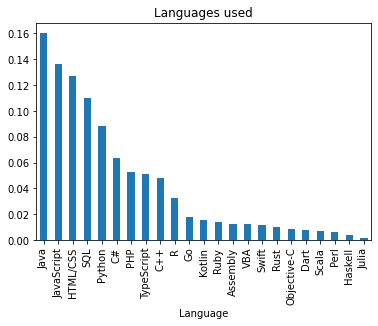

,langUsed_perc,langDesired_perc,Diff_lang_Vals
Language,,,
Java,0.160401,0.126054,-0.034347
Python,0.088659,0.106197,0.017538
JavaScript,0.136114,0.104231,-0.031883
HTML/CSS,0.126854,0.082671,-0.044184
SQL,0.110137,0.079483,-0.030655
TypeScript,0.051112,0.068259,0.017147
R,0.032582,0.066265,0.033682
C#,0.063254,0.054424,-0.008830
Go,0.017664,0.050169,0.032505


In [8]:
possible_language_vals = [ "Assembly", "Bash/Shell/PowerShell C", "C#", "C++", "Dart", "Go", "Haskell", "HTML/CSS", "Java", "JavaScript", "Julia", "Kotlin", "Objective-C", "Perl", "PHP", "Python", "R", "Ruby", "Rust", "Scala", "SQL", "Swift", "TypeScript", "VBA", "Other"]

def clean_and_plot(df, title='Languages used', plot=True, colName = 'LanguageWorkedWith'):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    language = df[colName].value_counts().reset_index()
    language.rename(columns={'index': 'Language', colName : 'count'}, inplace=True)
    language_df = t.total_count(language, 'Language', 'count', possible_language_vals)

    language_df.set_index('Language', inplace=True)
    if plot:
        (language_df/language_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_language_df = language_df/language_df.sum()

    return props_language_df


props_df = clean_and_plot(df20)

props_desired_df = clean_and_plot(df20, colName='LanguageDesireNextYear', title='desired language', plot=False)

comp_df = pd.merge(props_df, props_desired_df, left_index=True, right_index=True)
comp_df.columns = ['langUsed_perc', 'langDesired_perc']
comp_df['Diff_lang_Vals'] =  comp_df['langDesired_perc'] - comp_df['langUsed_perc']
comp_df.sort_values

comp_df = comp_df.iloc[comp_df.langDesired_perc.argsort()[::-1]]
comp_df.style.bar(subset=['Diff_lang_Vals'], align='mid', color=['#d65f5f', '#5fba7d'])





As illustrated in 1st figure, we can observe that Java programming language is widely used, as about 16% of the people have mentioned that they have used it in the past year. The list contains 23 programing language; however, only a few used widely and more than half of the languages in the list are used by less than 2% of the people.

As with spoken languages, it is worth it to analyze languages that people are considering to learn next year and those that are not. Records in the table are sorted by the percentage of people considering to work with the language in the upcoming year, where the difference column is to illustrate the difference between the number of people working with the language this year and want to work with it next year. Although the top five languages are still on the top of the list for the next year, except for Python, fewer people are considering to work with them next year. R, Rust, and Kotlin percentage of users could more than double in the upcoming year, but there is still a big gap for them to reach the top five.



<h3 id='q2'>Q2: Looking at the data for languages used and desired, is it different between developers by profession and others? </h3>



In [9]:

prof = df20[df20['MainBranch'] == "I am a developer by profession"] # Subset df to only to developer by profession  
notProf = df20[df20['MainBranch'] != "I am a developer by profession"] # Subset df to other than developer by proession

langUsed_prof_perc = clean_and_plot(prof, 'Developer by profession', plot=False)
langUsed_notProf_perc = clean_and_plot(notProf, 'Not prof', plot=False)

comp_df = pd.merge(langUsed_prof_perc, langUsed_notProf_perc, left_index=True, right_index=True)
comp_df.columns = ['langUsed_prof_perc', 'langUsed_notProf_perc']
comp_df['Diff_langUsed_Vals'] = comp_df['langUsed_prof_perc'] - comp_df['langUsed_notProf_perc']
comp_df.style.bar(subset=['Diff_langUsed_Vals'], align='mid', color=['#d65f5f', '#5fba7d'])


,langUsed_prof_perc,langUsed_notProf_perc,Diff_langUsed_Vals
Language,,,
Java,0.163778,0.150107,0.013671
JavaScript,0.142088,0.117906,0.024182
HTML/CSS,0.125492,0.131005,-0.005513
SQL,0.113278,0.100563,0.012715
Python,0.078248,0.120389,-0.042142
C#,0.066378,0.053730,0.012648
TypeScript,0.060097,0.023729,0.036368
PHP,0.051757,0.055235,-0.003478
C++,0.040335,0.071598,-0.031263


It turns out that languages in the top five are the same for both sets, but the order of usage is different. The above table provide more details in that regard; we can observe that the most significant difference between the two sets are in Python and TypeScript, where the first one is more popular among not coders by profession and the other is used more by developers by profession.

<h3 id='q3'>Q3: How job seeking is compared across different segmentation?</h3>

Analyze the job-seeking for different groups to see the overall picture. Two means that on average individuals on that group are looking for job and zero implies they are not looking for a job. I have added 0.5 for not actively looking, but looking for new opportunities because it would be closer to hold the current job.

In [10]:

print(df20.groupby(['JobSat']).mean()['jobSeekValue'].sort_values(ascending=False))
print()
print(df20.groupby(['UndergradMajor']).mean()['jobSeekValue'].sort_values(ascending=False))


JobSat
Slightly dissatisfied                 0.857090
Very dissatisfied                     0.849971
Neither satisfied nor dissatisfied    0.748654
Slightly satisfied                    0.542743
Very satisfied                        0.305908
Name: jobSeekValue, dtype: float64

UndergradMajor
Web development or web design                                                     0.722368
Information systems, information technology, or system administration             0.674192
Another engineering discipline (such as civil, electrical, mechanical, etc.)      0.645798
A social science (such as anthropology, psychology, political science, etc.)      0.643204
Computer science, computer engineering, or software engineering                   0.638461
A business discipline (such as accounting, finance, marketing, etc.)              0.619007
Fine arts or performing arts (such as graphic design, music, studio art, etc.)    0.608833
A health science (such as nursing, pharmacy, radiology, etc.)         

I have analyzed different segmentation groups; majority of them had a mean that is at 0.5 or more. The top groups I felt worth sharing are values for grouping by undergrad major and job satisfaction. Results are shared in the table below, and they were as expected for job satisfaction; the more people are satisfied, the less they will look for new jobs, and the opposite is true. For undergraduate major, it is interested to see that natural science majors are closer to hold the job while looking for new opportunities. On the other hand web designers are the most active in looking for new opportunities, maybe it is because the top-five languages can be linked to web development and there is a shortage in that area

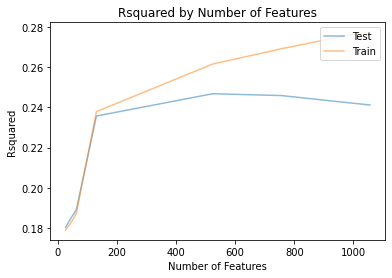

In [11]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = t.find_optimal_lm_mod(X, y, cutoffs)

In [12]:
print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2

524
0.24679930752001789
0.26155459642447976


In [13]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
170,"Employment_Not employed, but looking for work",0.803786,0.803786
287,JobSat_Very satisfied,-0.382253,0.382253
76,CurrencyDesc_Chinese Yuan Renminbi,-0.336980,0.336980
74,CurrencyDesc_Canadian dollar,-0.307050,0.307050
106,CurrencyDesc_Swedish krona,-0.306989,0.306989
90,CurrencyDesc_Mexican peso,-0.304842,0.304842
92,CurrencyDesc_New Zealand dollar,-0.280156,0.280156
94,CurrencyDesc_Norwegian krone,-0.264765,0.264765
361,NEWJobHunt_Wanting to share accomplishments wi...,0.253167,0.253167
68,Country_Viet Nam,0.238614,0.238614


When building a model to study the factors affecting the job seeking, the first one as expected is being Unemployed. Next top factor, was job satisfaction, in particular when being Very satisfied. As seen in table 4, when being very satisfied it affect job seeking in the opposite direction.